# Notebook to demonstrate Cascading Randomization on MNIST

In this notebook, we will take a trained CNN (on MNIST) and generate saliency maps of various kinds from this CNN and perform the cascading randomization as done in the paper "Sanity Checks for Saliency Maps".

**Before running this notebook** make sure that you have installed all the necessary dependencies. See the requirements.txt file in the top level folder for this. This notebook can be easily adapted to Fashion MNIST.

**Make sure you have a folder cnn_mnist in models directory with the CNN weights before running this notebook**

You can train a CNN on MNIST using *src/train_cnn_models.py* as follows:
```
python train_cnn_models.py --data mnist --savemodelpath ../models/ --reg --log
```

In [23]:
# take care of imports
from __future__ import absolute_import, division, print_function

%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # you can turn this on if you'd prefer to do this on a GPU
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
import seaborn as sns
import saliency
import pickle


import tensorflow.keras 
from tensorflow.keras.datasets import mnist, fashion_mnist
from matplotlib import gridspec
import seaborn as sns

from scipy.stats import spearmanr as spr # this is needed to compute the spearman rank correlation.
import pandas as pd

# some plotting defaults
sns.set_style('whitegrid', {'axes.grid': False})
SSIZE=10
MSIZE=12
BSIZE=14
plt.rc('font', size=SSIZE)
plt.rc('axes', titlesize=MSIZE)
plt.rc('axes', labelsize=MSIZE)
plt.rc('xtick', labelsize=MSIZE)
plt.rc('ytick', labelsize=MSIZE)
plt.rc('legend', fontsize=MSIZE)
plt.rc('figure', titlesize=MSIZE)
plt.rcParams['font.family'] = "sans-serif"

# A few utility functions

In [24]:
def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        img = saliency.VisualizeImageGrayscale(img)
    return img
def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.VisualizeImageDiverging(img)
    return img

def get_nist_data(mst=True,
                  validation=True,
                  norm_divisor=255.0,
                  label_to_categorical=True,
                  num_classes=10):
    if mst:
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    if norm_divisor:
        x_train = x_train/norm_divisor
        x_test = x_test/norm_divisor
    if validation:
        x_valid, x_train = x_train[:5000], x_train[5000:]
        y_valid, y_train = y_train[:5000], y_train[5000:]
    if label_to_categorical:
        y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)
        y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
    if validation:
        y_valid = tensorflow.keras.utils.to_categorical(y_valid, num_classes)
    return (x_train, x_valid, x_test), (y_train, y_valid, y_test)

def plot_single_img(img,
                    ax=False,
                    norm=diverging_norm,
                    show_axis=False,
                    grayscale=False,
                    cmap='gray',
                    title='',
                    fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)

# Saliency and Randomization Utility Functions  

In [25]:
def get_saliency_constructors(model_graph,
                              model_session,
                              logit_tensor,
                              input_tensor,
                              gradcam=False,
                              conv_layer_gradcam=None):
    """Returns functions to compute saliency masks for methods in saliency package.
    Args:
        model_graph: tf graph of the model for which saliency is to be computed.
        model_session: tf session in which the trained model has been loaded.
        logit_tensor: tensor corresponding to the logit output of the network.
        input_tensor: tensor coressponding to the input data.
        gradcam: Boolean to indicate whether to compute gradcam saliency maps.
        conv_layer_gradcam: tensor corresponding to activations from a conv layer,
                            from the trained model. Authors recommend last layer.
    
    Returns:
        saliency_constructor: dictionary where key is name of method, and value is 
                              function to each saliency method.
        
        neuron_selector: tensor to indicate which specific output to explain.
    """
    assert (type(tf.Graph()) == type(model_graph)), ("Model graph should be of type"
                                                     "{}".format(type(tf.Graph())))
    if gradcam and conv_layer_gradcam is None:
        raise ValueError("If gradcam is True, then conv_layer_gradcam is be provided.")
    
    #
    with model_graph.as_default():
        with tf.name_scope("saliency"):
            neuron_selector = tf.placeholder(tf.int32)
            y_salient = logit_tensor[neuron_selector] # this is the neuron to explain.
    gradient_saliency = saliency.tf1.GradientSaliency(model_graph,
                                                  model_session,
                                                  y_salient,
                                                  input_tensor)
    guided_backprop = saliency.tf1.GuidedBackprop(model_graph,
                                              model_session,
                                              y_salient,
                                              input_tensor)
    integrated_gradients = saliency.tf1.IntegratedGradients(model_graph,
                                                        model_session,
                                                        y_salient,
                                                        input_tensor)
    saliency_constructor = {'vng': gradient_saliency,
                            'gbp': guided_backprop,
                            'ig': integrated_gradients}
    
    if gradcam:
        gradcam = saliency.tf1.GradCam(model_graph,
                                   model_session,
                                   y_salient,
                                   input_tensor,
                                   conv_layer_gradcam)
        saliency_constructor['gc'] = gradcam
    
    return saliency_constructor, neuron_selector




def load_graph_and_randomize_layer(checkptpath,
                                   metapath,
                                   logitop="logits",
                                   inputop="x",
                                   gcamop="hidden2_hconv_act",
                                   randomize=False,
                                   layertorandomize=[]):
    tf.reset_default_graph()
    new_session = tf.Session()
    saver = tf.train.import_meta_graph(metapath)
    saver.restore(new_session, checkptpath)
    current_graph = tf.get_default_graph()
    y_logits_op = tf.get_collection(logitop)[0]
    input_op = tf.get_collection(inputop)[0]
    h2convact = None
    if gcamop:
        h2convact = tf.get_collection(gcamop)[0]
    trainable_ops = tf.trainable_variables()
    list_of_ops_to_randomize = []
    randparamlist = None

    if randomize:
        for layer in layertorandomize:
            for op in trainable_ops:
                if layer in op.name:
                    list_of_ops_to_randomize.append(op)
        with current_graph.as_default():
            to_ini = tf.initialize_variables(list_of_ops_to_randomize)
            _ = new_session.run(to_ini)
            randparamlist = new_session.run(trainable_ops)
    
    return (current_graph, new_session, y_logits_op, input_op, h2convact, trainable_ops, randparamlist)

# Let's compute a variety of saliency masks for the test inputs

In [28]:

import PIL
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch
from PIL import Image
import pysaliency
DEVICE = 'cuda'



def run_metrics(model: pysaliency.SaliencyMapModel , mit_stimuli, mit_fixations, cutoff=10):
	# print(mit_stimuli.filenames[:cutoff])
	short_stimuli = pysaliency.FileStimuli(filenames=mit_stimuli.filenames[:cutoff])
	short_fixations = mit_fixations[mit_fixations.n < cutoff]
	auc_uniform = model.AUC(short_stimuli, short_fixations, nonfixations='uniform', verbose=True)
	auc_shuffled = model.AUC(short_stimuli, short_fixations, nonfixations='shuffled', verbose=True)
	auc_identical_nonfixations = model.AUC(short_stimuli, short_fixations, nonfixations=short_fixations, verbose=True)
	kl_uniform = model.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations='uniform')
	kl_shuffled = model.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations='shuffled')
	kl_identical = model.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations=short_fixations)
	gold_standard = pysaliency.FixationMap(short_stimuli, short_fixations, kernel_size=30)
	image_based_kl = model.image_based_kl_divergence(short_stimuli, gold_standard)

	return auc_uniform, auc_shuffled, auc_identical_nonfixations, kl_uniform, kl_shuffled, kl_identical, image_based_kl
  
class SanityChecksSaliencyModel(pysaliency.SaliencyMapModel):
	
	def __init__(self, method: str, **kwargs):
		super().__init__()
		modelpath = '../models/cnn_mnist/' # update this to the relevant path for your model.
  
		assert method in ['Gradient', 'SmoothGrad', 'Guided\nBackProp', 'Integrated\nGradients', 'IG\nSmoothGrad', 'GradCAM']
		self.saliency_method = method
  
		# this will check that the files are in the desired paths
		if not os.path.exists(modelpath+"final_cnn_model_mnist.meta"):
			raise ValueError("final_cnn_model_mnist.meta not in the path specified.")
			
		if not os.path.exists(modelpath+"final_cnn_model_mnist.index"):
			raise ValueError("final_cnn_model_mnist.index not in the path specified.")


		# path to metapath and checkpoint path
		METAPATH = (modelpath + "final_cnn_model_mnist.meta")
		CHECKPOINTPATH = (modelpath + "final_cnn_model_mnist")

		# op names to load
		gradcamtensorname = "hidden2_hconv_act" # this is the name of the tensor in the graph for gradcam.
		logitop = "logits"
		inputop = "x"

		tf.reset_default_graph()
		self.new_session = tf.Session()
		saver = tf.train.import_meta_graph(METAPATH)
		saver.restore(self.new_session, CHECKPOINTPATH)
		self.current_graph = tf.get_default_graph()
		self.y_logits_op = tf.get_collection(logitop)[0]
		self.input_op = tf.get_collection(inputop)[0]
		self.h2convact = tf.get_collection(gradcamtensorname)[0]
		self.trainable_ops = tf.trainable_variables()
		
	def _saliency_map(self, stimulus):
		# setup constructor and methods
		saliency_dict, n_selector = get_saliency_constructors(self.new_session.graph,
															self.new_session,
															self.y_logits_op[0],
															self.input_op,
															gradcam=True,
															conv_layer_gradcam=self.h2convact)

		saliency_methods = {'Gradient': saliency_dict['vng'].GetMask,
							'SmoothGrad': saliency_dict['vng'].GetSmoothedMask,
							'Guided\nBackProp': saliency_dict['gbp'].GetMask,
							'Integrated\nGradients': saliency_dict['ig'].GetMask,
							'IG\nSmoothGrad': saliency_dict['ig'].GetSmoothedMask,
							'GradCAM': saliency_dict['gc'].GetMask}

		current_image = Image.fromarray(np.uint8(stimulus)).convert("RGB")
		sztple = (28, 28)
		current_image = current_image.resize(sztple, PIL.Image.ANTIALIAS)
		current_image = np.asarray(current_image)
		current_image = np.dot(current_image[...,:3], [0.2989, 0.5870, 0.1140])
		print(current_image.shape)

		baseline = np.zeros(current_image.shape)
		imglogits = self.new_session.run([self.y_logits_op],
										feed_dict={self.input_op: np.expand_dims(current_image, 0)})[0]
		
		prediction_class = imglogits.argmax() # this the output to explain.
		gen_feed_dict = {n_selector: prediction_class}
		
		# set up params for each saliency method
		saliency_params = {'Gradient': {"feed_dict": gen_feed_dict},
						'SmoothGrad': {"feed_dict": gen_feed_dict,
										"stdev_spread":0.15,
										"nsamples":50,
										"magnitude":False},
						'Guided\nBackProp': {"feed_dict": gen_feed_dict},
						'Integrated\nGradients': {"feed_dict": gen_feed_dict,
													"x_steps":50,
													"x_baseline":baseline},
						'IG\nSmoothGrad': {"feed_dict": gen_feed_dict,
											"x_steps":50,
											"stdev_spread": 0.15,
											"x_baseline":baseline,
											"magnitude":False},
						'GradCAM':{"feed_dict": gen_feed_dict,
									"three_dims": False}
						}    
		
		output_masks = {}
		key = self.saliency_method
		params = saliency_params[key]
		output_masks[key] = saliency_methods[key](current_image,**params)
		output = output_masks[key].reshape(28,28)
		# plt.imshow(output)
		# plt.show()
		return output
	
dataset_location = "../../datasets/"
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_mit1003(location=dataset_location)

model_zoo = ['Gradient', 'SmoothGrad', 'Guided\nBackProp', 'Integrated\nGradients', 'IG\nSmoothGrad', 'GradCAM']
model_instances = []

for model_name in model_zoo:
	model = SanityChecksSaliencyModel(method=model_name)
	model_instances.append(model)

cut_off = 10
overall_list_of_masks = []
for stimuli in mit_stimuli[0:cut_off]:
	list_of_masks = []
	for model in model_instances:
		smap = model.saliency_map(stimuli)
		list_of_masks.append(smap)
	overall_list_of_masks.append(list_of_masks)
 

INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist
INFO:tensorflow:Restoring parameters from ../models/cnn_mnist/final_cnn_model_mnist


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


  0%|          | 0/10 [00:00<?, ?it/s]

(28, 28)
the output saliency map is (28, 28), -0.4789155423641205,0.5192519426345825


IndexError: index 449 is out of bounds for axis 0 with size 28

# Let's process and visualize these masks

nrows:  10 ncols:  7


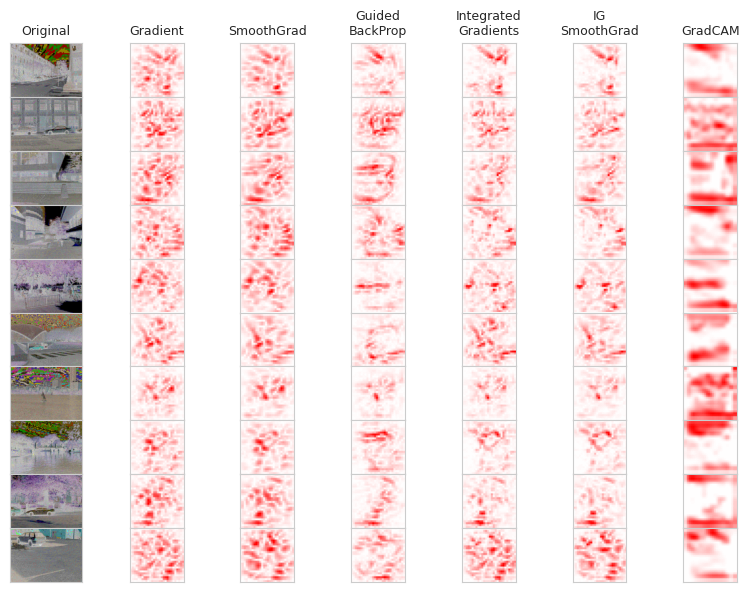

In [ ]:
def normalize_image(x):
	x = np.array(x).astype(np.float32)
	x_min = x.min()
	x_max = x.max()
	x_norm = (x - x_min) / (x_max - x_min)
	return x_norm

overall_list_of_masks_abs_norm = []
overall_list_of_masks_no_abs_norm = []
overall_list_of_masks_0_1_norm = []

for idx, list_of_masks in enumerate(overall_list_of_masks):
    
    list_of_masks_abs_norm = []
    list_of_masks_no_abs_norm = []
    list_of_masks_0_1_norm = []
    
    for i, mask in enumerate(list_of_masks):
        mask_abs_norm = abs_grayscale_norm(mask)
        mask_no_abs_norm = diverging_norm(mask)
        mask_0_1_norm = normalize_image(mask)
            
        list_of_masks_abs_norm.append(mask_abs_norm)
        list_of_masks_no_abs_norm.append(mask_no_abs_norm)
        list_of_masks_0_1_norm.append(mask_0_1_norm)
        
    overall_list_of_masks_abs_norm.append(list_of_masks_abs_norm)
    overall_list_of_masks_no_abs_norm.append(list_of_masks_no_abs_norm)
    overall_list_of_masks_0_1_norm.append(list_of_masks_0_1_norm)
    
overall_master_mask_list_abs_norm = []
overall_master_mask_list_no_abs_norm = []

for idx, (list_of_masks_abs_norm, list_of_masks_no_abs_norm, _) in enumerate(zip(overall_list_of_masks_abs_norm, overall_list_of_masks_no_abs_norm, overall_list_of_masks_0_1_norm)):
    master_mask_list_abs_norm = []
    master_mask_list_no_abs_norm = []
    
    og_img = mit_stimuli[:cut_off][idx].stimulus_data
    
    master_mask_list_abs_norm.append(og_img)
    master_mask_list_no_abs_norm.append(og_img)
    
    for i, (mask_abs_norm, mask_no_abs_norm) in enumerate(zip(list_of_masks_abs_norm,
                                                                    list_of_masks_no_abs_norm)):
        master_mask_list_abs_norm.append(mask_abs_norm)
        master_mask_list_no_abs_norm.append(mask_no_abs_norm)

    overall_master_mask_list_abs_norm.append(master_mask_list_abs_norm)
    overall_master_mask_list_no_abs_norm.append(master_mask_list_no_abs_norm)


nrows, ncols = cut_off, len(model_instances) + 1
print("nrows: ", nrows, "ncols: ", ncols)
fig = plt.figure(figsize=(cut_off, ncols))
gs = gridspec.GridSpec(nrows, ncols,
                       wspace=0.0, hspace=0.0)
cmap='bwr'
count = 0
titles = ["Original",'Gradient', 'SmoothGrad', 'Guided\nBackProp', 'Integrated\nGradients', 'IG\nSmoothGrad', 'GradCAM']
for i in range(nrows):
    master_mask_list_abs_norm = overall_master_mask_list_abs_norm[i]
    for j in range(ncols):
        ax = plt.subplot(gs[i, j])
        if (count==0) or (count%ncols==0):
            img = ((master_mask_list_abs_norm[j] + 1) * 127.5).astype(np.uint8)
            ax.imshow(img)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        else:
            ax.imshow(master_mask_list_abs_norm[j],
                      vmin=-1.0,
                      vmax=1.0,
                      cmap=cmap)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        if count < ncols:
            ax.set_title(titles[count], fontsize=9)
        count +=1
plt.show()

# Cascading randomization of layers 

In [ ]:
layer_names = ["softmax_linear", "fc1", "hidden2", "hidden1"] # model layer names from src/train_cnn_models.py

master_cascading_randomization_dictionary = {} # key will be layer name.
# for l_randomize_index, layer_name in enumerate(layer_randomization_order):
for ind, layer_name in enumerate(layer_names):
    # path to metapath and checkpoint path
    print("On layer {}".format(layer_name))
    # reintialize the required layer
    graphinfo = load_graph_and_randomize_layer(
                                   CHECKPOINTPATH,
                                   METAPATH,
                                   logitop="logits",
                                   inputop="x",
                                   gcamop="hidden2_hconv_act",
                                   randomize=True,
                                   layertorandomize=layer_names[:ind+1])
    current_graph = graphinfo[0]
    new_session = graphinfo[1]
    y_logits_op = graphinfo[2]
    input_op = graphinfo[3]
    h2convact = graphinfo[4]
    list_of_ops_training = graphinfo[5]
    randparamlist = graphinfo[6]
    
    # set up saliency dict and n_selector.
    saliency_dict, n_selector = get_saliency_constructors(new_session.graph,
                                                      new_session,
                                                      y_logits_op[0],
                                                      input_op,
                                                      gradcam=True,
                                                      conv_layer_gradcam=h2convact)
    
    saliency_methods = {'Gradient': saliency_dict['vng'].GetMask,
                        'SmoothGrad': saliency_dict['vng'].GetSmoothedMask,
                        'Guided\nBackProp': saliency_dict['gbp'].GetMask,
                        'Integrated\nGradients': saliency_dict['ig'].GetMask,
                        'IG\nSmoothGrad': saliency_dict['ig'].GetSmoothedMask,
                        'GradCAM': saliency_dict['gc'].GetMask}
    
    list_of_random_mask_per_layer = []
    for i, current_image in enumerate(demobatch):
        # print(i)
        baseline = np.zeros(current_image.shape)
        imglogits = new_session.run([y_logits_op],
                                        feed_dict={input_op: np.expand_dims(current_image, 0)})[0]

        prediction_class = imglogits.argmax() # this the output to explain.
        gen_feed_dict = {n_selector: prediction_class}

        # set up params for each saliency method
        saliency_params = {'Gradient': {"feed_dict": gen_feed_dict},
                           'SmoothGrad': {"feed_dict": gen_feed_dict,
                                          "stdev_spread":0.15,
                                          "nsamples":50,
                                          "magnitude":False},
                           'Guided\nBackProp': {"feed_dict": gen_feed_dict},
                           'Integrated\nGradients': {"feed_dict": gen_feed_dict,
                                                     "x_steps":50,
                                                     "x_baseline":baseline},
                           'IG\nSmoothGrad': {"feed_dict": gen_feed_dict,
                                              "x_steps":50,
                                              "stdev_spread": 0.15,
                                              "x_baseline":baseline,
                                              "magnitude":False},
                           'GradCAM':{"feed_dict": gen_feed_dict,
                                      "three_dims": False}
                          }    

        output_masks = {}
        for key in saliency_methods:
            # print("On {}".format(key))
            params = saliency_params[key]
            output_masks[key] = saliency_methods[key](current_image,**params)

        # compute some other methods
        # input-gradient and guided-gradcam
        output_masks["Input-Grad"] = output_masks['Gradient']*current_image
        output_masks["GBP-GC"] = output_masks['Guided\nBackProp']*output_masks['GradCAM']
        list_of_random_mask_per_layer.append(output_masks)
        
    # now add the list of random masks to the dictionary
    master_cascading_randomization_dictionary[layer_name] = list_of_random_mask_per_layer

W1109 00:54:36.355226 140585875457792 deprecation.py:323] From /home/julius/virtualenvs/sanity_checks2/lib/python3.5/site-packages/tensorflow_core/python/util/tf_should_use.py:198: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


On layer softmax_linear
On layer fc1
On layer hidden2
On layer hidden1


# Mask PostProcessing

In [ ]:
master_cascading_randomization_dictionary_abs_norm = {}
master_cascading_randomization_dictionary_no_abs_norm = {}

for layer in master_cascading_randomization_dictionary:
    mask_list_abs_norm = []
    mask_list_no_abs_norm = []
    for i, mask_dict in enumerate(master_cascading_randomization_dictionary[layer]):
    # first append original image
        new_dict_abs_norm = {}
        new_dict_no_abs_norm = {}
        for key in mask_dict:
            mask = mask_dict[key]
            mask_abs_norm = abs_grayscale_norm(mask)
            mask_no_abs_norm = diverging_norm(mask)
            new_dict_abs_norm[key] = mask_abs_norm
            new_dict_no_abs_norm[key] = mask_no_abs_norm
        mask_list_abs_norm.append(new_dict_abs_norm)
        mask_list_no_abs_norm.append(new_dict_no_abs_norm)
    master_cascading_randomization_dictionary_abs_norm[layer] = mask_list_abs_norm
    master_cascading_randomization_dictionary_no_abs_norm[layer] = mask_list_no_abs_norm

In [ ]:
for key in master_cascading_randomization_dictionary:
    assert len(master_cascading_randomization_dictionary[key])==len(master_cascading_randomization_dictionary_no_abs_norm[key])
    for i, item in enumerate(master_cascading_randomization_dictionary[key]):
        assert len(item)==len(master_cascading_randomization_dictionary_no_abs_norm[key][i])
for key in master_cascading_randomization_dictionary:
    assert len(master_cascading_randomization_dictionary[key])==len(master_cascading_randomization_dictionary_abs_norm[key])
    for i, item in enumerate(master_cascading_randomization_dictionary[key]):
        assert len(item)==len(master_cascading_randomization_dictionary_abs_norm[key][i])

# Let's plot cascading results

**Change the variable index_to_input_to_plot to visualize the other inputs**

We will only plot one input here. 

In [ ]:
cascading_master_plotting_list_abs_norm = []
cascading_master_plotting_list_no_abs_norm = []

index_to_input_to_plot = 0 # this must be less than the len of demo_batch
assert index_to_input_to_plot < demobatch.shape[0]


# Order that we want to show the masks in.
mask_order = ["Gradient", "SmoothGrad", "Guided\nBackProp",\
              "Integrated\nGradients", "Input-Grad", "IG\nSmoothGrad",\
              "GradCAM", "GBP-GC"]
layer_order = ["softmax_linear",
               "fc1", 
               "hidden2",
               "hidden1"]

for method in mask_order:
    # first insert normal saliency method
    normal_mask_abs_norm = list_of_masks_abs_norm[index_to_input_to_plot][method]
    normal_mask_no_abs_norm = list_of_masks_no_abs_norm[index_to_input_to_plot][method]
    cascading_master_plotting_list_abs_norm.append(normal_mask_abs_norm)
    cascading_master_plotting_list_no_abs_norm.append(normal_mask_no_abs_norm)
    for layer in layer_order:
        mask_abs_norm =  master_cascading_randomization_dictionary_abs_norm[layer][index_to_input_to_plot][method]
        cascading_master_plotting_list_abs_norm.append(mask_abs_norm)
        
        mask_no_abs_norm =  master_cascading_randomization_dictionary_no_abs_norm[layer][index_to_input_to_plot][method]
        cascading_master_plotting_list_no_abs_norm.append(mask_no_abs_norm)
        

print(len(cascading_master_plotting_list_abs_norm))
print(len(cascading_master_plotting_list_no_abs_norm))

40
40


# Rank Correlation Comparison Plots

Now let's compute rank correlation between maps derived from (partially) randomized models and those from the pre-trained model

In [ ]:
layer_order = ["softmax_linear",
               "fc1", 
               "hidden2",
               "hidden1"]
methods_list = list(master_cascading_randomization_dictionary_abs_norm['hidden1'][0].keys())
rank_correlation_dictionary_abs_norm = {}
rank_correlation_dictionary_no_abs_norm = {}

for layer in layer_order:
    rank_correlation_dictionary_abs_norm[layer] = {}
    rank_correlation_dictionary_no_abs_norm[layer] = {}
    for method in methods_list:
        rank_correlation_dictionary_abs_norm[layer][method] = []
        rank_correlation_dictionary_no_abs_norm[layer][method] = []
        
for layer in master_cascading_randomization_dictionary_abs_norm:
    for i, mask_dict in enumerate(master_cascading_randomization_dictionary_abs_norm[layer]):
        for method in methods_list:
            normal_mask_abs_norm = list_of_masks_abs_norm[i][method]
            normal_mask_no_abs_norm = list_of_masks_no_abs_norm[i][method]
            
            rand_mask_abs_norm = mask_dict[method]
            rand_mask_no_abs_norm =\
                master_cascading_randomization_dictionary_no_abs_norm[layer][i][method]
            
            # compute rank correlation
            rk_abs, _ = spr(normal_mask_abs_norm.flatten(), rand_mask_abs_norm.flatten())
            rk_no_abs, _ = spr(normal_mask_no_abs_norm.flatten(), rand_mask_no_abs_norm.flatten())
            
            rank_correlation_dictionary_abs_norm[layer][method].append(rk_abs)
            rank_correlation_dictionary_no_abs_norm[layer][method].append(rk_no_abs)

In [ ]:
rk_mean_dictionary = {}
rk_std_dictionary = {}
for key in rank_correlation_dictionary_abs_norm:
    rk_mean_dictionary[key] = {}
    rk_std_dictionary[key] = {}
    for key2 in rank_correlation_dictionary_abs_norm[key]:
        rk_mean_dictionary[key][key2] = np.mean(rank_correlation_dictionary_abs_norm[key][key2])
        rk_std_dictionary[key][key2] = np.std(rank_correlation_dictionary_abs_norm[key][key2])

In [ ]:
test_df = pd.DataFrame(rk_mean_dictionary)
test_df2 = pd.DataFrame(rk_std_dictionary)

# include no randomization
test_df["orig"] = [1.0]*test_df.shape[0]
test_df2["orig"] = [1.0]*test_df2.shape[0]

# switch order of the columns
layer_order = ["orig", "softmax_linear", "fc1", "hidden2", "hidden1"]
to_reverse = False
if to_reverse:
    layer_order = list(reversed(layer_order))
test_df = test_df.reindex(columns=layer_order)
test_df2 = test_df2.reindex(columns=layer_order)

In [ ]:
test_df

,orig,softmax_linear,fc1,hidden2,hidden1
GBP-GC,1.0,0.555383,0.358696,0.329324,0.282110
GradCAM,1.0,0.556216,0.343793,0.289925,0.298528
Gradient,1.0,0.601145,0.396089,0.105509,0.082446
Guided\nBackProp,1.0,0.887599,0.773429,0.628115,0.444149
IG\nSmoothGrad,1.0,0.576819,0.429279,0.379435,0.360800
Input-Grad,1.0,0.993185,0.992998,0.992692,0.991554
Integrated\nGradients,1.0,0.993986,0.993249,0.992580,0.991981
SmoothGrad,1.0,0.536286,0.329503,0.180300,0.212522


In [ ]:
test_df2

,orig,softmax_linear,fc1,hidden2,hidden1
GBP-GC,1.0,0.224080,0.175099,0.181245,0.108303
GradCAM,1.0,0.229029,0.184303,0.165087,0.133745
Gradient,1.0,0.084209,0.128551,0.052020,0.029827
Guided\nBackProp,1.0,0.031020,0.035153,0.073078,0.052636
IG\nSmoothGrad,1.0,0.079412,0.099085,0.087595,0.077747
Input-Grad,1.0,0.004555,0.004374,0.004342,0.005537
Integrated\nGradients,1.0,0.003495,0.003889,0.004832,0.004993
SmoothGrad,1.0,0.060488,0.032187,0.054181,0.024198


# Rank Correlation Plots with Positive Relevance Only masks

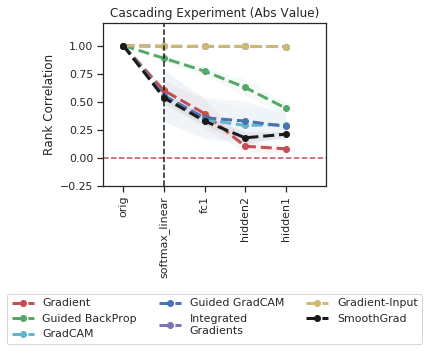

In [ ]:
sns.set(style="ticks")
plt.figure(figsize=(4,3))

gcam = test_df.iloc[[1]].values[0]
grad = test_df.iloc[[2]].values[0]
gbp = test_df.iloc[[3]].values[0]
ig = test_df.iloc[[6]].values[0]
ggcam = test_df.iloc[[0]].values[0]
inputgrad = test_df.iloc[[5]].values[0]
sgrad = test_df.iloc[[7]].values[0]

gcam_std = test_df2.iloc[[1]].values[0]
grad_std = test_df2.iloc[[2]].values[0]
gbp_std = test_df2.iloc[[3]].values[0]
ig_std = test_df2.iloc[[6]].values[0]
ggcam_std = test_df2.iloc[[0]].values[0]
inputgrad_std = test_df2.iloc[[5]].values[0]
sgrad_std = test_df2.iloc[[7]].values[0]


x = [i+1 for i in range(len(gcam))]
plt.plot(x, grad, 'ro-', lw=3, linestyle='--', label='Gradient')
plt.fill_between(x[1:], grad[1:]-grad_std[1:], grad[1:]+grad_std[1:], facecolor='r', alpha=0.05)

plt.plot(x, gbp, 'go-', lw=3, linestyle='--', label='Guided BackProp')
plt.fill_between(x[1:], gbp[1:]-gbp_std[1:], gbp[1:]+gbp_std[1:], facecolor='g', alpha=0.05)

plt.plot(x, gcam, 'co-', lw=3, linestyle='--', label='GradCAM')
plt.fill_between(x[1:], gcam[1:]-gcam_std[1:], gcam[1:]+gcam_std[1:], facecolor='c', alpha=0.05)

plt.plot(x, ggcam, 'bo-', lw=3, linestyle='--', label='Guided GradCAM')
plt.fill_between(x[1:], ggcam[1:]-ggcam_std[1:], ggcam[1:]+ggcam_std[1:], facecolor='b', alpha=0.05)

plt.plot(x, ig, 'mo-', lw=3, linestyle='--', label='Integrated\nGradients')
plt.fill_between(x[1:], ig[1:]-ig_std[1:], ig[1:]+ig_std[1:], facecolor='m', alpha=0.05)

plt.plot(x, inputgrad, 'yo-', linestyle='--', lw=3, label='Gradient-Input')
plt.fill_between(x[1:], inputgrad[1:]-inputgrad_std[1:], inputgrad[1:]+inputgrad_std[1:], facecolor='y', alpha=0.05)

plt.plot(x, sgrad, 'ko-', lw=3, linestyle='--', label='SmoothGrad')
plt.fill_between(x[1:], sgrad[1:]-sgrad_std[1:], sgrad[1:]+sgrad_std[1:], facecolor='k', alpha=0.05)

plt.xticks(x, layer_order)
plt.xticks(rotation=90)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axvline(x=2.0, ymin=0.0, ymax=1.0, color='k', linestyle='--')
plt.ylim([-0.25, 1.2])
plt.xlim([0.5, 6])
plt.ylabel("Rank Correlation")
plt.title("Cascading Experiment (Abs Value)")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.0), ncol=3)
plt.tick_params(axis='x', which='both', top='off')
plt.show()

# Rank Correlation Plot with Signed Masks

In [ ]:
rk_mean_dictionary_no_abs = {}
rk_std_dictionary_no_abs = {}
for key in rank_correlation_dictionary_no_abs_norm:
    rk_mean_dictionary_no_abs[key] = {}
    rk_std_dictionary_no_abs[key] = {}
    for key2 in rank_correlation_dictionary_no_abs_norm[key]:
        rk_mean_dictionary_no_abs[key][key2] = np.mean(rank_correlation_dictionary_no_abs_norm[key][key2])
        rk_std_dictionary_no_abs[key][key2] = np.std(rank_correlation_dictionary_no_abs_norm[key][key2])
        

test_df3 = pd.DataFrame(rk_mean_dictionary_no_abs)
test_df4 = pd.DataFrame(rk_std_dictionary_no_abs)

# include no randomization
test_df3["orig"] = [1.0]*test_df3.shape[0]
test_df4["orig"] = [1.0]*test_df4.shape[0]

# switch order of the columns
layer_order = ["orig", "softmax_linear", "fc1", "hidden2", "hidden1"]
to_reverse = False
if to_reverse:
    layer_order = list(reversed(layer_order))
test_df3 = test_df3.reindex(columns=layer_order)
test_df4 = test_df4.reindex(columns=layer_order)

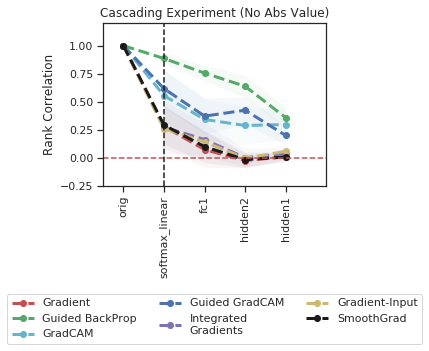

In [ ]:
sns.set(style="ticks")
plt.figure(figsize=(4,3))

gcam = test_df3.iloc[[1]].values[0]
grad = test_df3.iloc[[2]].values[0]
gbp = test_df3.iloc[[3]].values[0]
ig = test_df3.iloc[[6]].values[0]
ggcam = test_df3.iloc[[0]].values[0]
inputgrad = test_df3.iloc[[5]].values[0]
sgrad = test_df3.iloc[[7]].values[0]

gcam_std = test_df4.iloc[[1]].values[0]
grad_std = test_df4.iloc[[2]].values[0]
gbp_std = test_df4.iloc[[3]].values[0]
ig_std = test_df4.iloc[[6]].values[0]
ggcam_std = test_df4.iloc[[0]].values[0]
inputgrad_std = test_df2.iloc[[5]].values[0]
sgrad_std = test_df4.iloc[[7]].values[0]


x = [i+1 for i in range(len(gcam))]
plt.plot(x, grad, 'ro-', lw=3, linestyle='--', label='Gradient')
plt.fill_between(x[1:], grad[1:]-grad_std[1:], grad[1:]+grad_std[1:], facecolor='r', alpha=0.05)

plt.plot(x, gbp, 'go-', lw=3, linestyle='--', label='Guided BackProp')
plt.fill_between(x[1:], gbp[1:]-gbp_std[1:], gbp[1:]+gbp_std[1:], facecolor='g', alpha=0.05)

plt.plot(x, gcam, 'co-', lw=3, linestyle='--', label='GradCAM')
plt.fill_between(x[1:], gcam[1:]-gcam_std[1:], gcam[1:]+gcam_std[1:], facecolor='c', alpha=0.05)

plt.plot(x, ggcam, 'bo-', lw=3, linestyle='--', label='Guided GradCAM')
plt.fill_between(x[1:], ggcam[1:]-ggcam_std[1:], ggcam[1:]+ggcam_std[1:], facecolor='b', alpha=0.05)

plt.plot(x, ig, 'mo-', lw=3, linestyle='--', label='Integrated\nGradients')
plt.fill_between(x[1:], ig[1:]-ig_std[1:], ig[1:]+ig_std[1:], facecolor='m', alpha=0.05)

plt.plot(x, inputgrad, 'yo-', linestyle='--', lw=3, label='Gradient-Input')
plt.fill_between(x[1:], inputgrad[1:]-inputgrad_std[1:], inputgrad[1:]+inputgrad_std[1:], facecolor='y', alpha=0.05)

plt.plot(x, sgrad, 'ko-', lw=3, linestyle='--', label='SmoothGrad')
plt.fill_between(x[1:], sgrad[1:]-sgrad_std[1:], sgrad[1:]+sgrad_std[1:], facecolor='k', alpha=0.05)

plt.xticks(x, layer_order)
plt.xticks(rotation=90)
plt.axhline(y=0.0, color='r', linestyle='--')
plt.axvline(x=2.0, ymin=0.0, ymax=1.0, color='k', linestyle='--')
plt.ylim([-0.25, 1.2])
plt.xlim([0.5, 6])
plt.ylabel("Rank Correlation")
plt.title("Cascading Experiment (No Abs Value)")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.0), ncol=3)
plt.tick_params(axis='x', which='both', top='off')
plt.show()